In [2]:
import os
import pandas as pd
import re
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [193]:
station_all = pd.read_excel("station_with_elevation_heightcanopy.xlsx")

In [194]:
station_all

,station_name,latitude,longitude,elevation,height_canopy_ETH,sd_height_canopy,height_canopy_field_information,Measurement height,IGBP long name,IGBP short name,Remarks
0,BE-Maa,50.979870,5.631851,85.895432,12.0,9.00,0.7,1.0,Closed Shrublands,CSH,measurement height not found.
1,BE-Lon,50.551620,4.746234,168.590302,1.0,0.00,1.0,2.7,Croplands,CRO,height_canopy from modelevaluation
2,CZ-KrP,49.573257,15.078773,543.737488,1.0,0.00,1.0,10.0,Croplands,CRO,https://www.sciencedirect.com/science/article/...
3,FI-Qvd,60.295242,22.391607,5.679937,4.0,2.00,0.5,2.3,Croplands,CRO,NaN
4,FR-Aur,43.549650,1.106103,244.314011,1.0,0.00,1.0,3.5,Croplands,CRO,https://www.sciencedirect.com/science/article/...
...,...,...,...,...,...,...,...,...,...,...,...
63,ES-LM1,39.942690,-5.778683,264.104858,8.7,1.25,8.0,15.0,Savannas,SAV,https://agupubs.onlinelibrary.wiley.com/doi/10...
64,ES-LM2,39.934592,-5.775881,268.699219,8.7,1.25,8.0,15.0,Savannas,SAV,https://agupubs.onlinelibrary.wiley.com/doi/10...
65,CZ-wet,49.024700,14.770400,1180.554932,1.0,0.00,0.3,2.0,Permanent Wetlands,WET,height_canopy from modelevaluation
66,DE-Akm,53.866170,13.683420,0.241400,13.0,6.00,4.0,NaN,Permanent Wetlands,WET,measurement height not found.


In [188]:
station_passing_threshold = pd.read_excel("thresholdp25.xlsx", header = 0)

In [189]:
# Select rows where the column "Year_2018_In_Range" is True
selected_stations = station_passing_threshold[station_passing_threshold['Year_2018_In_Range'] == True]

In [190]:
selected_stations = selected_stations.rename(columns={"Site_code": "station_name"})

In [104]:
# Replace underscores with hyphens in the "station_name" column
selected_stations['station_name'] = selected_stations['station_name'].str.replace('_', '-')
selected_stations.head()

,station_name,Start_Year_Threshold,End_Year_Threshold,Actual_Start_Year,Actual_End_Year,Year_2018_In_Range
0,BE-Bra,2011-01-01,2019-01-01,1996-01-01,2020-01-01,True
1,BE-Dor,2011-01-01,2020-01-01,2011-01-01,2020-01-01,True
5,BE-Vie,2010-01-01,2019-01-01,1996-01-01,2020-01-01,True
7,CH-Cha,2006-01-01,2019-01-01,2005-01-01,2020-01-01,True
8,CH-Dav,1997-01-01,2019-01-01,1997-01-01,2020-01-01,True


In [179]:
# Perform an inner join based on the 'station_name' column
station = pd.merge(selected_stations, station_all, on='station_name', how='inner')

# Print or view the merged DataFrame
# Apply the offset to change the dates to December 31st of the same year
station['End_Year_Threshold'] = station['End_Year_Threshold'] + pd.offsets.YearBegin(1)
#station.to_csv("StationsInfothresholdp25.csv", index=False)

In [195]:
# Initialize an empty dictionary to store station_name, latitude, and longitude
station_dict = {}

# Iterate over each row in the DataFrame
for index, row in station_all.iterrows():
    # Extract the station_name and position
    station_name = row['station_name']
    latitude = row['latitude']
    longitude = row['longitude']
    elevation = row['elevation']
    IGBP_longname = row['IGBP long name']
    IGBP_shortname = row['IGBP short name']
    #start_year = row['Start_Year_Threshold']
    #end_year = row['End_Year_Threshold']
    
    # Extract height_canopy from 'height_canopy_field_information' column or 'height_canopy_ETH' column
    height_canopy = row['height_canopy_field_information']
    if pd.isna(height_canopy):  # Check if height_canopy_field_information is NaN
        height_canopy = row['height_canopy_ETH']

    measurement_height = row['Measurement height']
    
    # Store the station_name, latitude, and longitude in the dictionary
    station_dict[station_name] = {
        'latitude': latitude, 
        'longitude': longitude, 
        'elevation' : elevation,
        'IGBP_longname': IGBP_longname,
        'IGBP_shortname': IGBP_shortname,
        'height_canopy': height_canopy,
        'measurement_height': measurement_height,
        #'start_year': start_year,
        #'end_year': end_year
    }

In [117]:
def list_folders_with_prefix(location, prefix):
    folders_with_prefix = [folder for folder in os.listdir(location) if os.path.isdir(os.path.join(location, folder)) and folder.startswith(prefix)]
    return folders_with_prefix

In [118]:
def list_csv_files_in_folder(folder_path, keyword):
    csv_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv') and keyword in file]
    return csv_files

In [119]:
location = "/home/khanalp/task1/data/"
prefix = "FLX"
folders = list_folders_with_prefix(location, prefix)

In [120]:
csv_files_with_keyword = []
for folder in folders:
    folder_path = os.path.join(location, folder)
    csv_files_with_keyword.extend(list_csv_files_in_folder(folder_path, "FULLSET_HH"))

In [197]:
# Initialize an empty DataFrame to store results
results_df = pd.DataFrame()

In [198]:
# Specify the variables of interest
variables_of_interest = [
    'TA_F', 'TA_F_QC', 'SW_IN_F', 'SW_IN_F_QC', 'LW_IN_F', 'LW_IN_F_QC', 
    'VPD_F', 'VPD_F_QC', 'PA_F', 'PA_F_QC', 'P_F', 'P_F_QC', 'WS_F', 
    'WS_F_QC', 'RH', 'CO2_F_MDS', 'CO2_F_MDS_QC'
]

In [175]:
for station_name, station_info in station_dict.items():

    #print(station_name)
    selected_item = None

    for item in csv_files_with_keyword:
        if station_name in item:
            selected_item = item
            break

    #start_year = station_info['start_year']
    #end_year = station_info['end_year']
    #print(selected_item)
    
    df = pd.read_csv(selected_item)
    #df['TIMESTAMP_START'] = pd.to_datetime(df['TIMESTAMP_START'], format='%Y%m%d%H%M')

    # Select observations within the date range for the current station
    #station_data = df[(df['TIMESTAMP_START'] >= start_year) & (df['TIMESTAMP_START'] < end_year)]
    
    # Filter the DataFrame to include only the variables of interest
    df_filtered = df[variables_of_interest]
        
    # Count occurrences of -9999 for each variable and store in a dictionary
    counts = {var: np.count_nonzero(df_filtered[var].values == -9999) for var in df_filtered.columns}

    results_df = results_df.append(pd.Series(counts, name=station_name))

/tmp/ipykernel_3427700/937353487.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series(counts, name=station_name))
/tmp/ipykernel_3427700/937353487.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series(counts, name=station_name))
/tmp/ipykernel_3427700/937353487.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series(counts, name=station_name))
/tmp/ipykernel_3427700/937353487.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series(counts, name=station_name))
/tmp/ipykernel_3427700/9

In [199]:
for station_name, station_info in station_dict.items():
    try:
        selected_item = next(item for item in csv_files_with_keyword if station_name in item)
        df = pd.read_csv(selected_item)
        
        # Filter the DataFrame to include only the variables of interest
        df_filtered = df[variables_of_interest]
        
        # Count occurrences of -9999 for each variable and store in a dictionary
        counts = {var: np.count_nonzero(df_filtered[var].values == -9999) for var in df_filtered.columns}

        # Append the counts to the results DataFrame
        results_df = results_df.append(pd.Series(counts, name=station_name))
    except StopIteration:
        print(f"CSV file not found for station: {station_name}. Skipping...")

/tmp/ipykernel_3427700/3172753719.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series(counts, name=station_name))
/tmp/ipykernel_3427700/3172753719.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series(counts, name=station_name))
/tmp/ipykernel_3427700/3172753719.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series(counts, name=station_name))
/tmp/ipykernel_3427700/3172753719.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series(counts, name=station_name))
/tmp/ipykernel_34277

CSV file not found for station: NL-Spe. Skipping...


/tmp/ipykernel_3427700/3172753719.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series(counts, name=station_name))
/tmp/ipykernel_3427700/3172753719.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series(counts, name=station_name))
/tmp/ipykernel_3427700/3172753719.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series(counts, name=station_name))
/tmp/ipykernel_3427700/3172753719.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series(counts, name=station_name))
/tmp/ipykernel_34277

In [201]:
results_df.columns

Index(['TA_F', 'TA_F_QC', 'SW_IN_F', 'SW_IN_F_QC', 'LW_IN_F', 'LW_IN_F_QC',
       'VPD_F', 'VPD_F_QC', 'PA_F', 'PA_F_QC', 'P_F', 'P_F_QC', 'WS_F',
       'WS_F_QC', 'RH', 'CO2_F_MDS', 'CO2_F_MDS_QC'],
      dtype='object')

In [219]:
analysis = results_df[['TA_F', 'TA_F_QC', 'SW_IN_F', 'SW_IN_F_QC', 'LW_IN_F', 'LW_IN_F_QC',
       'VPD_F', 'VPD_F_QC', 'PA_F', 'PA_F_QC', 'P_F', 'P_F_QC', 'WS_F',
       'WS_F_QC']]
# Select rows where all values are zero across all columns
zero_rows = analysis[(analysis == 0).all(axis=1)]

# Print or view the selected rows
len(zero_rows)

34

In [223]:
analysis.index

Index(['BE-Maa', 'BE-Lon', 'CZ-KrP', 'FI-Qvd', 'FR-Aur', 'FR-Gri', 'FR-Lam',
       'DE-Geb', 'DE-Kli', 'DE-RuS', 'IT-BCi', 'CH-Oe2', 'CZ-Lnz', 'CZ-Stn',
       'DK-Sor', 'FR-Fon', 'FR-Hes', 'DE-Hai', 'DE-HoH', 'DE-Hzd', 'GF-Guy',
       'BE-Bra', 'CZ-BK1', 'CZ-RAJ', 'FI-Hyy', 'FI-Ken', 'FI-Let', 'FI-Var',
       'FR-Bil', 'FR-FBn', 'DE-RuW', 'DE-Tha', 'DE-Obe', 'IL-Yat', 'IT-Ren',
       'IT-SR2', 'IT-Lav', 'RU-Fy2', 'RU-Fyo', 'SE-Htm', 'SE-Nor', 'SE-Svb',
       'SE-Ros', 'CH-Dav', 'BE-Dor', 'FR-Tou', 'DE-Gri', 'DE-RuR', 'IT-MBo',
       'IT-Tor', 'CH-Aws', 'CH-Cha', 'CH-Fru', 'BE-Vie', 'IT-Cp2', 'IT-Lsn',
       'ES-Agu', 'ES-LJu', 'FI-Sii', 'FR-LGt', 'SE-Deg', 'ES-Abr', 'ES-LM1',
       'ES-LM2', 'CZ-wet', 'DE-Akm', 'ES-Cnd'],
      dtype='object')

In [227]:
# Select rows from 'analysis_df' that are also present in 'zero_rows'
selected_rows = results_df[results_df.index.isin(zero_rows.index)]

In [230]:
selected_rows.to_csv("sites_with_noNAs.csv",index = True)

In [220]:
#results_df.to_csv("Overview_of_no_of_NAs_Stationthresholdp25.csv", index = True)
zero_rows

,TA_F,TA_F_QC,SW_IN_F,SW_IN_F_QC,LW_IN_F,LW_IN_F_QC,VPD_F,VPD_F_QC,PA_F,PA_F_QC,P_F,P_F_QC,WS_F,WS_F_QC
BE-Lon,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CZ-KrP,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FI-Qvd,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FR-Aur,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FR-Gri,0,0,0,0,0,0,0,0,0,0,0,0,0,0
DE-RuS,0,0,0,0,0,0,0,0,0,0,0,0,0,0
IT-BCi,0,0,0,0,0,0,0,0,0,0,0,0,0,0
DK-Sor,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FR-Fon,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FR-Hes,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [216]:
results_df.tail()

,TA_F,TA_F_QC,SW_IN_F,SW_IN_F_QC,LW_IN_F,LW_IN_F_QC,VPD_F,VPD_F_QC,PA_F,PA_F_QC,P_F,P_F_QC,WS_F,WS_F_QC,RH,CO2_F_MDS,CO2_F_MDS_QC
ES-LM1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3700,3026,3026
ES-LM2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3559,3026,3026
CZ-wet,0,0,0,0,0,0,0,0,17568,17568,17568,17568,17568,17568,31431,4928,4928
DE-Akm,0,0,0,0,0,0,0,0,17568,17568,17568,17568,17568,17568,64108,17850,17850
ES-Cnd,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37464,13472,13472


In [84]:
df = pd.read_csv(selected_item)

In [85]:
print(df.columns)

Index(['TIMESTAMP_START', 'TIMESTAMP_END', 'TA_F_MDS', 'TA_F_MDS_QC', 'TA_ERA',
       'TA_F', 'TA_F_QC', 'SW_IN_POT', 'SW_IN_F_MDS', 'SW_IN_F_MDS_QC',
       ...
       'GPP_DT_CUT_SE', 'GPP_DT_CUT_05', 'GPP_DT_CUT_16', 'GPP_DT_CUT_25',
       'GPP_DT_CUT_50', 'GPP_DT_CUT_75', 'GPP_DT_CUT_84', 'GPP_DT_CUT_95',
       'RECO_SR', 'RECO_SR_N'],
      dtype='object', length=243)


In [86]:
xds = xr.Dataset.from_dataframe(df)

In [87]:
#selecting required variables
variables = [
    'TIMESTAMP_START',
    'TA_F',
    'TA_F_QC',
    'SW_IN_F',
    'SW_IN_F_QC',
    'LW_IN_F',
    'LW_IN_F_QC',
    'VPD_F',
    'VPD_F_QC',
    'PA_F',
    'PA_F_QC',
    'P_F',
    'P_F_QC',
    'WS_F',
    'WS_F_QC',
    'RH',
    'CO2_F_MDS',
    'CO2_F_MDS_QC' 
]

selected = xds[variables]

In [88]:
#Renaming them
rename = {'TA_F':'Tair',
          'TA_F_QC':'Tair_qc',
          'SW_IN_F':'SWdown',
          'SW_IN_F_QC':'SWdown_qc',
          'LW_IN_F':'LWdown',
          'LW_IN_F_QC':'LWdown_qc',
          'VPD_F':'VPD',
          'VPD_F_QC':'VPD_qc',
          'PA_F':'Psurf',
          'PA_F_QC':'Psurf_qc',
          'P_F' : 'Precip',
          'P_F_QC':'Precip_qc',
          'WS_F':'Wind',
          'WS_F_QC':'Wind_qc',
          'CO2_F_MDS':'CO2air_qc',
          'CO2_F_MDS_QC':'CO2air'
         }
ds_with_name = selected.rename(rename)

In [89]:
ds_with_name

<xarray.Dataset>
Dimensions:          (index: 87696)
Coordinates:
  * index            (index) int64 0 1 2 3 4 5 ... 87691 87692 87693 87694 87695
Data variables: (12/18)
    TIMESTAMP_START  (index) int64 201601010000 201601010030 ... 202012312330
    Tair             (index) float64 5.505 5.587 5.668 ... 3.49 3.507 3.439
    Tair_qc          (index) int64 2 2 2 2 2 2 2 2 2 2 2 ... 3 3 3 3 3 3 3 3 3 3
    SWdown           (index) float64 0.0 0.0 0.0 0.0 0.006 ... 0.0 0.0 0.0 0.0
    SWdown_qc        (index) int64 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
    LWdown           (index) float64 274.1 274.1 287.6 ... 324.2 324.5 327.1
    ...               ...
    Precip_qc        (index) int64 2 2 2 2 2 2 ... -9999 -9999 -9999 -9999 -9999
    Wind             (index) float64 1.68 1.845 1.814 ... -9.999e+03 -9.999e+03
    Wind_qc          (index) int64 0 0 0 0 0 0 ... -9999 -9999 -9999 -9999 -9999
    RH               (index) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    CO2air_qc        (index) float64 364.5 363.5 363.3 ... 418.7 418.9 419.3
    CO2air           (index) int64 0 0 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2 2

In [90]:
#Making date and time as index; renaming index to time
ds_index_date_time = ds_with_name.assign_coords(index=pd.to_datetime(ds_with_name['TIMESTAMP_START'], format='%Y%m%d%H%M')).rename({'index':'time'})
ds_index_date_time

<xarray.Dataset>
Dimensions:          (time: 87696)
Coordinates:
  * time             (time) datetime64[ns] 2016-01-01 ... 2020-12-31T23:30:00
Data variables: (12/18)
    TIMESTAMP_START  (time) int64 201601010000 201601010030 ... 202012312330
    Tair             (time) float64 5.505 5.587 5.668 5.702 ... 3.49 3.507 3.439
    Tair_qc          (time) int64 2 2 2 2 2 2 2 2 2 2 2 ... 3 3 3 3 3 3 3 3 3 3
    SWdown           (time) float64 0.0 0.0 0.0 0.0 0.006 ... 0.0 0.0 0.0 0.0
    SWdown_qc        (time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
    LWdown           (time) float64 274.1 274.1 287.6 ... 324.2 324.5 327.1
    ...               ...
    Precip_qc        (time) int64 2 2 2 2 2 2 ... -9999 -9999 -9999 -9999 -9999
    Wind             (time) float64 1.68 1.845 1.814 ... -9.999e+03 -9.999e+03
    Wind_qc          (time) int64 0 0 0 0 0 0 ... -9999 -9999 -9999 -9999 -9999
    RH               (time) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    CO2air_qc        (time) float64 364.5 363.5 363.3 ... 418.7 418.9 419.3
    CO2air           (time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2 2

In [91]:
# Adding x,y to the dimensions; also dropping variable 'TIMESTAMP_START' because its already indexed
ds_dimensions = ds_index_date_time.expand_dims({'x': [1], 'y': [2]}).drop_vars('TIMESTAMP_START')
ds_dimensions

<xarray.Dataset>
Dimensions:    (x: 1, y: 1, time: 87696)
Coordinates:
  * x          (x) int64 1
  * y          (y) int64 2
  * time       (time) datetime64[ns] 2016-01-01 ... 2020-12-31T23:30:00
Data variables: (12/17)
    Tair       (x, y, time) float64 5.505 5.587 5.668 5.702 ... 3.49 3.507 3.439
    Tair_qc    (x, y, time) int64 2 2 2 2 2 2 2 2 2 2 2 ... 3 3 3 3 3 3 3 3 3 3
    SWdown     (x, y, time) float64 0.0 0.0 0.0 0.0 0.006 ... 0.0 0.0 0.0 0.0
    SWdown_qc  (x, y, time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
    LWdown     (x, y, time) float64 274.1 274.1 287.6 ... 324.2 324.5 327.1
    LWdown_qc  (x, y, time) int64 2 2 2 2 2 2 2 2 2 2 2 ... 3 3 3 3 3 3 3 3 3 3
    ...         ...
    Precip_qc  (x, y, time) int64 2 2 2 2 2 2 ... -9999 -9999 -9999 -9999 -9999
    Wind       (x, y, time) float64 1.68 1.845 1.814 ... -9.999e+03 -9.999e+03
    Wind_qc    (x, y, time) int64 0 0 0 0 0 0 ... -9999 -9999 -9999 -9999 -9999
    RH         (x, y, time) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    CO2air_qc  (x, y, time) float64 364.5 363.5 363.3 ... 418.7 418.9 419.3
    CO2air     (x, y, time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2 2

In [92]:
# Convert all data variables to float32
for var_name in ds_dimensions.data_vars:
    ds_dimensions[var_name] = ds_dimensions[var_name].astype('float32')

In [ ]:
#Converting x,y to float64 
ds_dimensions['x'] = ds_dimensions['x'].astype('float64')
ds_dimensions['y'] = ds_dimensions['y'].astype('float64')

In [45]:
# Define the end date of the desired range; this is because this has good quality data. 
# This should later be checked. 
end_date = '2019-12-31T23:30:00'

# Select data up to the desired end date
ds_final = ds_dimensions.sel(time=slice(None, end_date))

In [46]:
ds_final

<xarray.Dataset>
Dimensions:    (x: 1, y: 1, time: 420768)
Coordinates:
  * x          (x) float64 1.0
  * y          (y) float64 2.0
  * time       (time) datetime64[ns] 1996-01-01 ... 2019-12-31T23:30:00
Data variables: (12/17)
    Tair       (x, y, time) float32 1.513 1.581 1.648 ... 1.996 1.823 1.921
    Tair_qc    (x, y, time) float32 2.0 2.0 2.0 2.0 2.0 ... 0.0 0.0 0.0 0.0 0.0
    SWdown     (x, y, time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.003
    SWdown_qc  (x, y, time) float32 2.0 2.0 2.0 2.0 2.0 ... 0.0 0.0 0.0 0.0 0.0
    LWdown     (x, y, time) float32 335.2 335.2 335.8 ... 324.2 324.0 324.5
    LWdown_qc  (x, y, time) float32 2.0 2.0 2.0 2.0 2.0 ... 0.0 0.0 0.0 0.0 0.0
    ...         ...
    Precip_qc  (x, y, time) float32 2.0 2.0 2.0 2.0 2.0 ... 0.0 0.0 0.0 0.0 0.0
    Wind       (x, y, time) float32 1.32 1.305 1.29 1.274 ... 2.909 3.112 2.181
    Wind_qc    (x, y, time) float32 2.0 2.0 2.0 2.0 2.0 ... 0.0 0.0 0.0 0.0 0.0
    RH         (x, y, time) float32 -9.999e+03 -9.999e+03 ... 99.6 99.6
    CO2air_qc  (x, y, time) float32 -9.999e+03 -9.999e+03 ... 480.8 482.6
    CO2air     (x, y, time) float32 -9.999e+03 -9.999e+03 -9.999e+03 ... 0.0 0.0

In [47]:
# counting -9999 (which is the NA data in the data variables)
for var in ds_final.data_vars:
    print({var:np.count_nonzero(ds_final[var].values == -9999)} )

{'Tair': 0}
{'Tair_qc': 0}
{'SWdown': 0}
{'SWdown_qc': 0}
{'LWdown': 0}
{'LWdown_qc': 0}
{'VPD': 0}
{'VPD_qc': 0}
{'Psurf': 0}
{'Psurf_qc': 0}
{'Precip': 0}
{'Precip_qc': 0}
{'Wind': 0}
{'Wind_qc': 0}
{'RH': 56429}
{'CO2air_qc': 53121}
{'CO2air': 53121}


The RH and CO2air has the non available values

In [48]:
# List of variables you want to replace -9999 with NaN
variables_to_replace = [ 'RH','CO2air']

# Iterate over the variables and replace -9999 with NaN
for var_name in variables_to_replace:
    ds_final[var_name] = ds_final[var_name].where(ds_final[var_name] != -9999, np.nan)
    ds_final[var_name] = ds_final[var_name].interpolate_na(dim='time', method='linear')

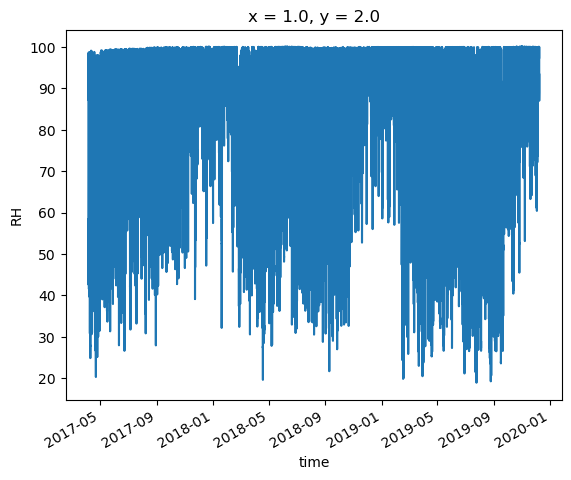

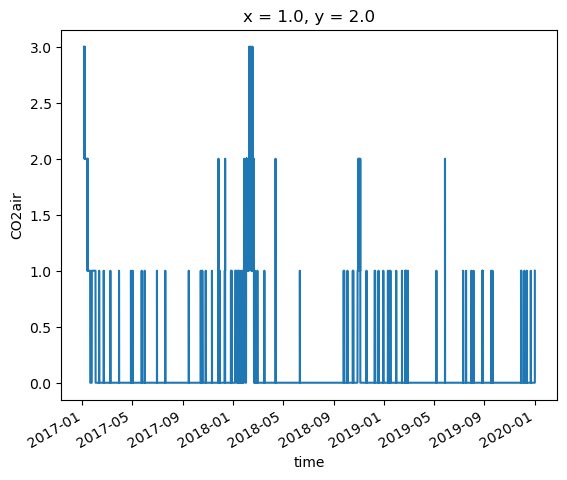

In [61]:
# Replace -9999 with NaN in Psurf variable
for var_name in variables_to_replace:
    ds_final[var_name].plot()
    plt.show()

**Not so satisfied with the TS of RH and C02 air. I need to calculate first RH (from VPD and Ta) and then Qair(specific humidity) from RH, T and Pressure (P)**

Given T is temperature in degrees Celsius, and RH is relative humidity:

Saturation Vapor Pressure (es) =0.6108 * exp(17.27 * T / (T + 237.3)) # This gives KPa. Since, 1 KPa = 10 hPA, which is the unit of vpd in the datatset. 
Vapor Pressure Deficit (vpd) = saturated vapor pressure (es) - actual vapor pressure(ea) 
so, ea = es - vpd 

Then, Actual Vapor Pressure (ea) = RH / 100 * es 
So, RH = ea*100/es

Reference: https://physics.stackexchange.com/questions/4343/how-can-i-calculate-vapor-pressure-deficit-from-temperature-and-relative-humidit

To get specific humidity (mass of water vapor to mass of moist air) from RH, e and Pressure, see this: 
https://earthscience.stackexchange.com/questions/5076/how-to-calculate-specific-humidity-with-relative-humidity-temperature-and-pres



In [63]:
#Grabbing input vpd,Tair, pressure
vpd = ds_final.VPD.values.flatten()
Tair = ds_final.Tair.values.flatten()
pressure = ds_final .Psurf.values.flatten()

In [64]:
# calculating saturation vapor pressure (es) from the Tair.
es = 0.6108 * np.exp((17.27 * Tair) / (Tair + 237.3)) *10

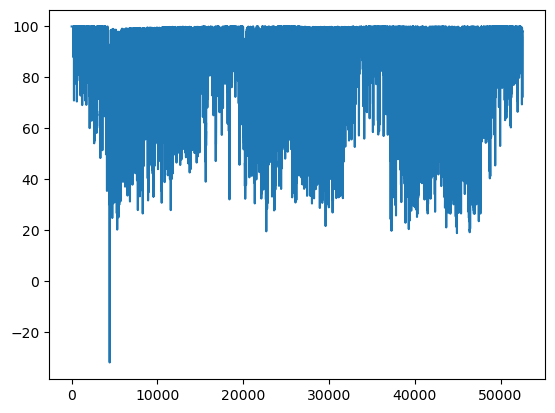

In [68]:
# calculating the actual vapor pressure from es and vpd and then RH. Change this with function later.
ea = es -  vpd
RH = (ea/es)*100
plt.plot(RH)

**You can see there are some negative values, just replacing them with them the mean of the nearest positive value.**

In [69]:
def replace_negative_with_mean_of_nearest(arr):
    neg_indices = np.where(arr < 0)[0]  # Get indices where values are less than zero
    for i in neg_indices:
        # Find nearest non-negative values before and after the negative value
        left_index = i - 1
        while left_index in neg_indices:
            left_index -= 1
        right_index = i + 1
        while right_index in neg_indices:
            right_index += 1

        # Replace negative value with the mean of the nearest non-negative values
        arr[i] = np.mean([arr[left_index], arr[right_index]])

    return arr

In [70]:
RH_modified = replace_negative_with_mean_of_nearest(RH)

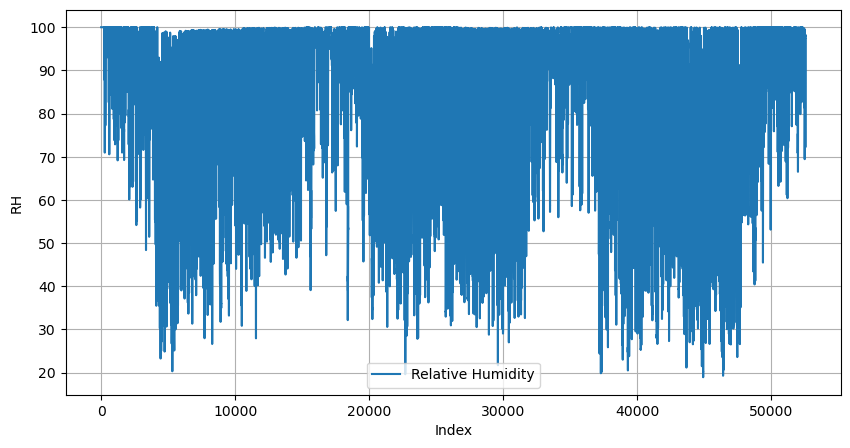

In [71]:
plt.figure(figsize=(10, 5))
plt.plot(RH_modified, label='Relative Humidity')
plt.xlabel('Index')
plt.ylabel('RH')
#plt.title('Anomaly Data')
plt.legend()
plt.grid(True)
# Plot red dots at positions where p has NaN
plt.show()

Now, this looks fine, with no negative values.

In [72]:
# Gas constant of dry air and vapor.
Rd = 287.058
Rv = 461.5

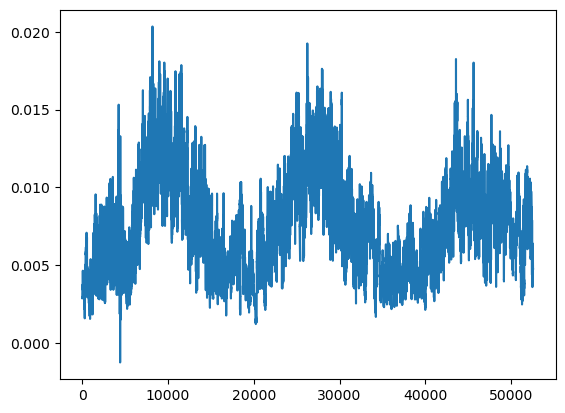

In [74]:
#calculating the specific humidity (q) from ea. 
w = ea * Rd / (Rv*(pressure*10-ea)) # Since pressure in KPa, ea in hPa, same as VPD. 
q = w/(w+1)
plt.plot(q)
#This has some negative values.

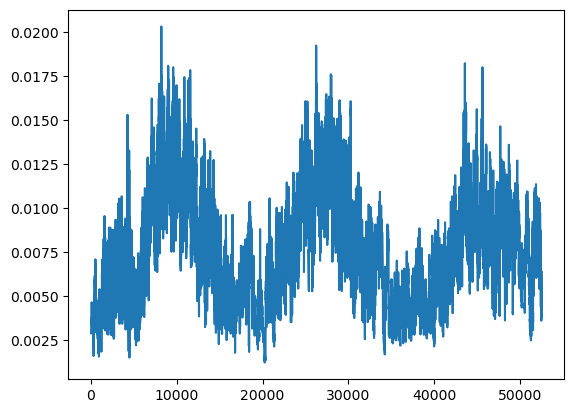

In [75]:
qair_modified = replace_negative_with_mean_of_nearest(q)
plt.plot(qair_modified)

In [100]:
ds_final['Qair'] = xr.DataArray(qair_modified.reshape(1,1,-1), dims=['x','y','time'])

In [102]:
ds_final['RH'] = xr.DataArray(RH_modified.reshape(1,1,-1), dims=['x','y','time'])

In [103]:
ds_final

<xarray.Dataset>
Dimensions:    (x: 1, y: 1, time: 52560)
Coordinates:
  * x          (x) float64 1.0
  * y          (y) float64 2.0
  * time       (time) datetime64[ns] 2017-01-01 ... 2019-12-31T23:30:00
Data variables: (12/18)
    Tair       (x, y, time) float32 -3.415 -3.434 -3.55 ... 3.42 3.416 3.51
    Tair_qc    (x, y, time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SWdown     (x, y, time) float32 0.68 0.68 0.68 0.68 0.68 ... 0.0 0.0 0.0 0.0
    SWdown_qc  (x, y, time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    LWdown     (x, y, time) float32 277.5 277.5 285.8 ... 307.8 308.0 308.5
    LWdown_qc  (x, y, time) float32 2.0 2.0 2.0 2.0 2.0 ... 0.0 0.0 0.0 0.0 0.0
    ...         ...
    Wind       (x, y, time) float32 0.464 0.455 0.447 ... 0.097 0.094 0.411
    Wind_qc    (x, y, time) float32 2.0 2.0 2.0 2.0 2.0 ... 0.0 0.0 0.0 0.0 2.0
    RH         (x, y, time) float32 100.0 100.0 100.0 ... 97.98 97.99 98.01
    CO2air_qc  (x, y, time) float32 -9.999e+03 -9.999e+03 ... 425.4 425.3
    CO2air     (x, y, time) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 1.0
    Qair       (x, y, time) float32 0.002926 0.002923 ... 0.004704 0.004736

In [26]:
## Getting CAMS data for co2
cams = xr.open_dataset("/home/khanalp/task1/data/cams/cams_europe.nc").sortby('time')

In [27]:
# Create coordinate arrays for longitude and latitude
lon_values = [2.284102]  # Replace with your actual longitude value
lat_values = [47.322918]  # Replace with your actual latitude value

# Assign the coordinate arrays to the dataset
#ds_final = ds_final.assign_coords({'x': lon_values, 'y': lat_values})

NameError: name 'ds_final' is not defined

In [29]:
cams_location_selected = cams.sel(longitude=2.284102, latitude=47.322918, method='nearest')
#cams_date_selected = cams_location_selected.sel(time=slice(ds_final.time.min().values, ds_final.time.max().values))

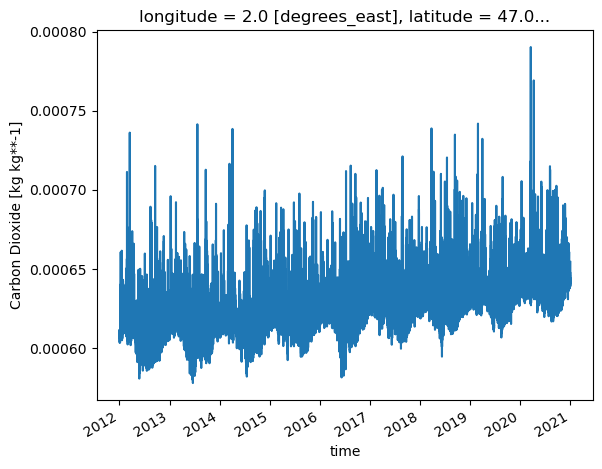

In [32]:
cams_location_selected['co2'].plot()

In [34]:
co2 = cams_location_selected['co2'].values

In [38]:
molar_mass_co2 = 44.01  # g/mol
molecular_mass_dry_air = 28.97  # g/mol

ppm_co2 = (co2 * molecular_mass_dry_air / molar_mass_co2) * 1e6

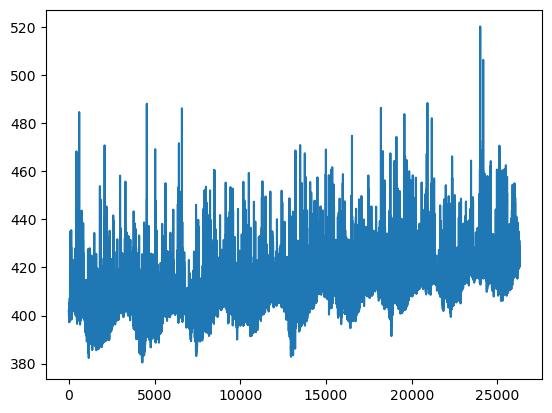

In [39]:
plt.plot(ppm_co2)

In [157]:
# Select time and co2 variables
time_data = cams_date_selected['time'].values
co2_data = cams_date_selected['co2'].values

# Create a pandas DataFrame
df = pd.DataFrame({'time': time_data, 'co2': co2_data})

In [158]:
#Setting Date column as index to do resample to 30 mins, which is the resolution of flux tower.
df.set_index('time', inplace=True)
df_filled = df.resample('30min').ffill()

In [159]:
# Reindex to extend the index until '2020-12-31' and forward fill
end_date_extend = pd.to_datetime('2019-12-31 23:30')
df_filled_new = df_filled.reindex(pd.date_range(start=df_filled.index.min(), end=end_date_extend, freq='30min')).ffill()

In [160]:
co2 = np.array(df_filled_new['co2'])

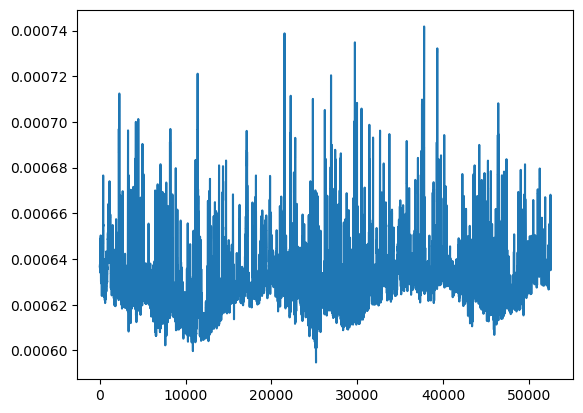

In [161]:
plt.plot(co2)

In [162]:
ds_final['CO2air'] = xr.DataArray(co2.reshape(1,1,-1), dims=['x','y','time'])

In [164]:
# Getting LAI
lai = pd.read_excel('/home/khanalp/task1/output/data_LAI_processed.xlsx', index_col = 0)

In [166]:
# Select data within the specified time range
selected_lai = lai.loc['2017-01-01 00:00:00':'2019-12-31 23:30:00']

In [168]:
np_lai = np.array(selected_lai['LAI_final'])

In [169]:
#For now, i keep both LAI and LAI_alternative from the MODIS data.
ds_final['LAI'] = xr.DataArray(np_lai.reshape(1,1,-1), dims=['x','y','time'])

In [170]:
ds_final['LAI_alternative'] = xr.DataArray(np_lai.reshape(1,1,-1), dims=['x','y','time'])

In [194]:
# I need to automatize all the processes from here. 

In [182]:
reference_height = 12.5 
canopy_height = 15
elevation = 154.75

In [183]:
ds_final['latitude'] = xr.DataArray(np.array(lat_values).reshape(1,-1), dims=['x','y'])
ds_final['longitude'] = xr.DataArray(np.array(lon_values).reshape(1,-1), dims=['x','y'])
ds_final['reference_height'] = xr.DataArray(np.array(reference_height).reshape(1,-1), dims=['x','y'])
ds_final['canopy_height'] = xr.DataArray(np.array(canopy_height).reshape(1,-1), dims=['x','y'])
ds_final['elevation'] = xr.DataArray(np.array(elevation).reshape(1,-1), dims=['x','y'])

In [192]:
ds_final['IGBP_veg_short'] = xr.DataArray(np.array('ENF', dtype = 'S200'))
ds_final['IGBP_veg_long'] = xr.DataArray(np.array('Evergreen Needleleaf Forests', dtype = 'S200'))

In [196]:
ds_final.to_netcdf("/home/khanalp/code/PhD/output/Fr-Lgt_2017-2019_FLUXNET2015_Met.nc")

In [7]:
abc = xr.open_dataset("/home/khanalp/code/PhD/output/FR-Lgt_2017-2019_FLUXNET2015_Met.nc")

In [11]:
abc['IGBP_veg_long'] = xr.DataArray(np.array('Evergreen Needleleaf Forests', dtype = 'S200'))

In [13]:
abc.to_netcdf("/home/khanalp/STEMMUSSCOPE/STEMMUS_SCOPE/input/Plumber2_data//FR-Lgt_2017-2019_FLUXNET2015_Met.nc")

In [10]:
import numpy as np

In [1]:
import xarray as xr

In [5]:
abc = xr.open_dataset("/home/khanalp/STEMMUSSCOPE/STEMMUS_SCOPE/input/Plumber2_data//FR-Lgt_2017-2019_FLUXNET2015_Met.nc")

In [12]:
abc.data_vars

Data variables:
    Tair              (x, y, time) float32 ...
    Tair_qc           (x, y, time) float32 ...
    SWdown            (x, y, time) float32 ...
    SWdown_qc         (x, y, time) float32 ...
    LWdown            (x, y, time) float32 ...
    LWdown_qc         (x, y, time) float32 ...
    VPD               (x, y, time) float32 ...
    VPD_qc            (x, y, time) float32 ...
    Psurf             (x, y, time) float32 ...
    Psurf_qc          (x, y, time) float32 ...
    Precip            (x, y, time) float32 ...
    Precip_qc         (x, y, time) float32 ...
    Wind              (x, y, time) float32 ...
    Wind_qc           (x, y, time) float32 ...
    RH                (x, y, time) float32 ...
    CO2air_qc         (x, y, time) float32 ...
    CO2air            (x, y, time) float32 ...
    Qair              (x, y, time) float32 ...
    LAI               (x, y, time) float64 ...
    LAI_alternative   (x, y, time) float64 ...
    latitude          (x, y) float64 ...
   

In [13]:
for var_name in abc.data_vars:
    if var_name not in ['IGBP_veg_short', 'IGBP_veg_long']:
        abc[var_name] = abc[var_name].astype('float32')

In [18]:
abc.to_netcdf("/home/khanalp/code/PhD/output/FR-Lgt_2017-2019_FLUXNET2015_Met.nc")

In [19]:
xyz = xr.open_dataset("/home/khanalp/STEMMUSSCOPE/STEMMUS_SCOPE/input/Plumber2_data/FR-Lgt_2017-2019_FLUXNET2015_Met.nc")

In [20]:
xyz

<xarray.Dataset>
Dimensions:           (x: 1, y: 1, time: 52560)
Coordinates:
  * x                 (x) float64 2.284
  * y                 (y) float64 47.32
  * time              (time) datetime64[ns] 2017-01-01 ... 2019-12-31T23:30:00
Data variables: (12/27)
    Tair              (x, y, time) float32 ...
    Tair_qc           (x, y, time) float32 ...
    SWdown            (x, y, time) float32 ...
    SWdown_qc         (x, y, time) float32 ...
    LWdown            (x, y, time) float32 ...
    LWdown_qc         (x, y, time) float32 ...
    ...                ...
    longitude         (x, y) float32 ...
    reference_height  (x, y) float32 ...
    canopy_height     (x, y) float32 ...
    elevation         (x, y) float32 ...
    IGBP_veg_short    |S200 ...
    IGBP_veg_long     |S200 ...

In [13]:
Plumber_2 = xr.open_dataset("~/STEMMUSSCOPE/STEMMUS_SCOPE/input/Plumber2_data/US-Blo_2000-2006_FLUXNET2015_Met.nc")

In [24]:
Plumber_2

<xarray.Dataset>
Dimensions:           (x: 1, y: 1, time: 122736)
Coordinates:
  * x                 (x) float64 1.0
  * y                 (y) float64 1.0
  * time              (time) datetime64[ns] 2000-01-01 ... 2006-12-31T23:30:00
Data variables: (12/29)
    Tair              (time, y, x) float32 272.6 272.6 272.4 ... 275.3 274.9
    Tair_qc           (time, y, x) float32 ...
    SWdown            (time, y, x) float32 ...
    SWdown_qc         (time, y, x) float32 ...
    LWdown            (time, y, x) float32 ...
    LWdown_qc         (time, y, x) float32 ...
    ...                ...
    canopy_height     (y, x) float32 ...
    elevation         (y, x) float32 ...
    IGBP_veg_short    |S200 ...
    IGBP_veg_long     |S200 ...
    LAI_alternative   (time, y, x) float32 ...
    LAI               (time, y, x) float32 ...
Attributes: (12/43)
    Production_time:           2020-12-08 17:44:09
    Github_revision:           ae0fd8fae5edc749df76eb905f65f79e9eb46136-dirty
    site_code:                 US-Blo
    site_name:                 Blodgett Forest
    country:                   California, United States
    Fluxnet_dataset_version:   1-3
    ...                        ...
    time_coverage_start:       1992-01-01
    time_coverage_end:         2018-12-01
    geospatial_lat_min:        -90.0
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0

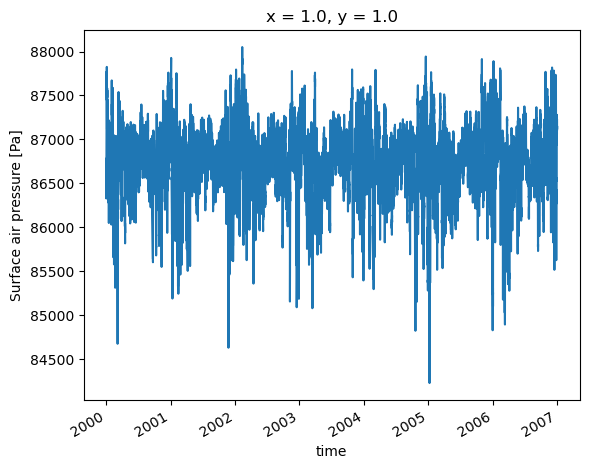

In [23]:
Plumber_2.Psurf.plot()

In [12]:
import xarray as xr

In [6]:
initial_condition = xr.open_dataset("/home/khanalp/STEMMUSSCOPE/STEMMUS_SCOPE/input/Initial_condition/US-Blo_20000101_00-land_skin_temperature_2000_hourly_121W-121W_39N-39N.nc")

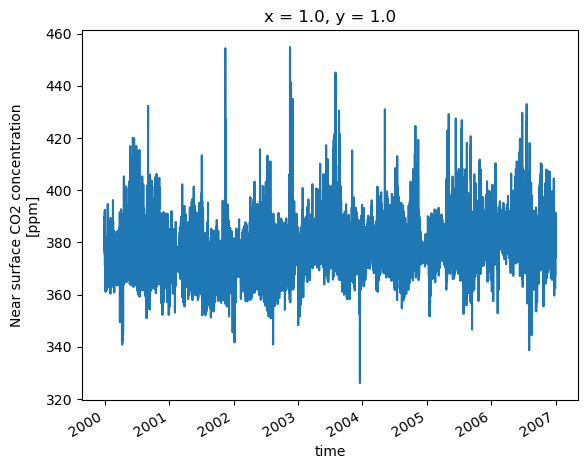

In [25]:
Plumber_2.CO2air.plot()

In [202]:
initial_condition

<xarray.Dataset>
Dimensions:    (longitude: 1, latitude: 1, time: 1)
Coordinates:
  * longitude  (longitude) float32 -120.6
  * latitude   (latitude) float32 38.89
  * time       (time) datetime64[ns] 2000-01-01
Data variables:
    skt        (time, latitude, longitude) float32 280.9
Attributes:
    Conventions:  CF-1.6
    history:      2022-06-04 15:02:47 UTC by era5cli 1.3.1: reanalysis-era5-l...

In [187]:
Plumber_2['IGBP_veg_long'].values

array(b'Evergreen Needleleaf Forests                                                                                                                                                                            ',
      dtype='|S200')

In [ ]:
Plumber_2['LAI'].values.plot()

In [ ]:
Plumber_2['LAI'].shape

In [ ]:
squeezed_LAI = Plumber_2['Qir'].squeeze()

In [ ]:
squeezed_LAI.plot()

In [ ]:
Plumber_2['Qair'].squeeze().plot()

In [ ]:
Plumber_2['VPD'].squeeze().plot()